## Install Gurobi

In [1]:
!pip install gurobipy


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### Import packages

In [2]:
import numpy as np
from gurobipy import *
import pandas as pd
import matplotlib.pyplot as plt

## Mount drive to be able to access data

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

# #!ls /content/drive/My\ Drive/

## First stage model

### Load in data

In [4]:
# Load CSV data
# file_path = '/content/drive/My Drive/DABP Project/ev_charging_congestion.csv'
file_path = 'ev_charging_congestion.csv'
data = pd.read_csv(file_path)

data.head()

,County,Public Level 1,Shared Private Level 1,Public Level 2,Shared Private Level 2,Public DC Fast,Shared Private DC Fast,Total_chargers,Total_EV,Total_Capacity_Level_1,Total_Capacity_Level_2,Total_Capacity_DC_Fast,Total_Charger_Capacity,Sessions_Level_1,Sessions_Level_2,Sessions_DC_Fast,Total_Effective_Sessions,Congestion_Ratio
0,Alameda,4,72,1590,3667,510,50,5893,57097,9120,3154200,4032000,7195320,31.92,12616.8,18816.0,31464.72,1.814636
1,Alpine,0,0,12,0,0,0,12,12,0,7200,0,7200,0.00,28.8,0.0,28.80,0.416667
2,Amador,0,0,26,0,8,0,34,269,0,15600,57600,73200,0.00,62.4,268.8,331.20,0.812198
3,Butte,6,0,72,53,25,1,157,1310,720,75000,187200,262920,2.52,300.0,873.6,1176.12,1.113832
4,Calaveras,0,2,9,0,12,0,23,334,240,5400,86400,92040,0.84,21.6,403.2,425.64,0.784701


In [5]:
population_density = pd.read_csv('table-data.csv')
population_density = population_density[['county', 'densityMi']]
population_density['county'] = population_density['county'].str[:-7]
population_density.head()

,county,densityMi
0,Los Angeles,2366.237685
1,San Diego,775.004751
2,Orange,3935.861286
3,Riverside,348.265085
4,San Bernardino,109.443592


In [6]:
data = pd.merge(data, population_density, left_on='County', right_on='county', how='left')
data.head()

,County,Public Level 1,Shared Private Level 1,Public Level 2,Shared Private Level 2,Public DC Fast,Shared Private DC Fast,Total_chargers,Total_EV,Total_Capacity_Level_1,Total_Capacity_Level_2,Total_Capacity_DC_Fast,Total_Charger_Capacity,Sessions_Level_1,Sessions_Level_2,Sessions_DC_Fast,Total_Effective_Sessions,Congestion_Ratio,county,densityMi
0,Alameda,4,72,1590,3667,510,50,5893,57097,9120,3154200,4032000,7195320,31.92,12616.8,18816.0,31464.72,1.814636,Alameda,2192.831750
1,Alpine,0,0,12,0,0,0,12,12,0,7200,0,7200,0.00,28.8,0.0,28.80,0.416667,Alpine,1.479675
2,Amador,0,0,26,0,8,0,34,269,0,15600,57600,73200,0.00,62.4,268.8,331.20,0.812198,Amador,70.805042
3,Butte,6,0,72,53,25,1,157,1310,720,75000,187200,262920,2.52,300.0,873.6,1176.12,1.113832,Butte,126.512836
4,Calaveras,0,2,9,0,12,0,23,334,240,5400,86400,92040,0.84,21.6,403.2,425.64,0.784701,Calaveras,45.660784


In [7]:
data.drop(columns=['county'], inplace=True)
data.columns

Index(['County', 'Public Level 1', 'Shared Private Level 1', 'Public Level 2',
       'Shared Private Level 2', 'Public DC Fast', 'Shared Private DC Fast',
       'Total_chargers', 'Total_EV', 'Total_Capacity_Level_1',
       'Total_Capacity_Level_2', 'Total_Capacity_DC_Fast',
       'Total_Charger_Capacity', 'Sessions_Level_1', 'Sessions_Level_2',
       'Sessions_DC_Fast', 'Total_Effective_Sessions', 'Congestion_Ratio',
       'densityMi'],
      dtype='object')

### Extract data, create first stage model

GOOD RESULT

In [8]:
from gurobipy import Model, GRB, quicksum

# Extract data from the DataFrame
counties = data['County'].tolist()
total_evs = dict(zip(data['County'], data['Total_EV']))
total_capacity = dict(zip(data['County'], data['Total_Charger_Capacity']))
congestion_ratio = dict(zip(data['County'], data['Congestion_Ratio']))

# Cost and budget data
charger_cost = 5000  # Cost per charger
budget = 32000000  # Budget available
congestion_weight = 1000  # Emphasis on reducing congestion

# Calculate minimum chargers based on EVs: 1 charger per 50 EVs
min_chargers = {county: max(0, total_evs[county] // 1000) for county in counties}

# First Stage: Infrastructure Planning
first_stage_model = Model("FirstStage")

# Decision variables: Number of chargers per county
chargers = first_stage_model.addVars(counties, vtype=GRB.INTEGER, name="Chargers")

# Objective: Minimize the weighted sum of congestion and cost
first_stage_model.setObjective(
    quicksum(congestion_weight * congestion_ratio[county] * chargers[county] for county in counties),
    GRB.MINIMIZE
)

# Constraints
for county in counties:
    # Congestion ratio constraint
    first_stage_model.addConstr(
        congestion_ratio[county] * chargers[county] <= total_capacity[county] * 0.9,  # Relaxed to 90%
        f"CongestionRatio_{county}"
    )
    # Demand satisfaction constraint: Ensure chargers meet EVs in the county
    first_stage_model.addConstr(
        chargers[county] * total_capacity[county] >= total_evs[county] * 1.1,  # Increased demand requirement
        f"Demand_{county}"
    )
    # Minimum chargers constraint based on EVs
    first_stage_model.addConstr(
        chargers[county] >= min_chargers[county],
        f"MinChargers_{county}"
    )

# Budget constraint
first_stage_model.addConstr(
    quicksum(charger_cost * chargers[county] for county in counties) <= budget,
    "BudgetConstraint"
)

# Solve the model
first_stage_model.optimize()

# Extract and print results
if first_stage_model.Status == GRB.OPTIMAL:
    optimal_chargers = {county: chargers[county].X for county in counties}
    print("First Stage Results (Optimal Chargers):", optimal_chargers)
else:
    print("First Stage Optimization Failed")


Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-30
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: 12th Gen Intel(R) Core(TM) i7-1255U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 175 rows, 58 columns and 232 nonzeros
Model fingerprint: 0xe676245f
Variable types: 0 continuous, 58 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e-02, 3e+07]
  Objective range  [1e+01, 1e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 3e+07]
Found heuristic solution: objective 1278767.2027
Presolve removed 175 rows and 58 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 12 available processors)

Solution count 1: 1.27877e+06 

Optimal solution found (tolerance 1.00e-04)
Best objective

New best?

In [9]:
from gurobipy import Model, GRB, quicksum

# Extract data from the DataFrame
counties = data['County'].tolist()
total_evs = dict(zip(data['County'], data['Total_EV']))
total_capacity = dict(zip(data['County'], data['Total_Charger_Capacity']))
congestion_ratio = dict(zip(data['County'], data['Congestion_Ratio']))

# Cost and budget data
charger_cost = 5000  # Cost per charger
budget = 32000000  # Budget available
congestion_weight = 1000  # Emphasis on reducing congestion

# Calculate minimum chargers based on EVs: 1 charger per 50 EVs
min_chargers = {county: max(0, total_evs[county] // 1000) for county in counties}

# First Stage: Infrastructure Planning
first_stage_model = Model("FirstStage")

# Decision variables: Number of chargers per county
chargers = first_stage_model.addVars(counties, vtype=GRB.INTEGER, name="Chargers")

# Objective: Minimize the weighted sum of congestion and cost
# Adjusted to place more emphasis on congestion
first_stage_model.setObjective(
    quicksum(congestion_weight * congestion_ratio[county] * chargers[county] for county in counties) +
    quicksum(charger_cost * chargers[county] for county in counties),
    GRB.MINIMIZE
)

# Constraints
for county in counties:
    # Congestion ratio constraint
    first_stage_model.addConstr(
        congestion_ratio[county] * chargers[county] <= total_capacity[county] * 1,  # Relaxed to 90%
        f"CongestionRatio_{county}"
    )
    # Demand satisfaction constraint: Ensure chargers meet EVs in the county
    first_stage_model.addConstr(
        chargers[county] * total_capacity[county] >= total_evs[county] * 1.1,  # Increased demand requirement
        f"Demand_{county}"
    )
    # Minimum chargers constraint based on EVs
    first_stage_model.addConstr(
        chargers[county] >= min_chargers[county],
        f"MinChargers_{county}"
    )

    # Encourage more chargers in high-congestion counties
    first_stage_model.addConstr(
    chargers[county] >= congestion_ratio[county] * 10,  # Example multiplier
    f"PrioritizeHighCongestion_{county}"
)

# Budget constraint
first_stage_model.addConstr(
    quicksum(charger_cost * chargers[county] for county in counties) <= budget,
    "BudgetConstraint"
)

# Solve the model
first_stage_model.optimize()

# Extract and print results
if first_stage_model.Status == GRB.OPTIMAL:
    optimal_chargers = {county: chargers[county].X for county in counties}
    print("First Stage Results (Optimal Chargers):", optimal_chargers)
else:
    print("First Stage Optimization Failed")


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: 12th Gen Intel(R) Core(TM) i7-1255U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 233 rows, 58 columns and 290 nonzeros
Model fingerprint: 0xb6f205eb
Variable types: 0 continuous, 58 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e-02, 3e+07]
  Objective range  [5e+03, 2e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+07]
Found heuristic solution: objective 8976293.8380
Presolve removed 233 rows and 58 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 12 available processors)

Solution count 1: 8.97629e+06 

Optimal solution found (tolerance 1.00e-04)
Best objective 8.976293837992e+06, best bound 8.976293837992e+06, gap 0.0000%
First Stage Results (Optima

In [10]:
optimal_chargers

{'Alameda': 57.0,
 'Alpine': 5.0,
 'Amador': 9.0,
 'Butte': 12.0,
 'Calaveras': 8.0,
 'Colusa': 2.0,
 'Contra Costa': 33.0,
 'Del Norte': 2.0,
 'El Dorado': 12.0,
 'Fresno': 7.0,
 'Glenn': 5.0,
 'Humboldt': 12.0,
 'Imperial': 6.0,
 'Inyo': 1.0,
 'Kern': 4.0,
 'Kings': 2.0,
 'Lake': 106.0,
 'Lassen': 1.0,
 'Los Angeles': 207.0,
 'Madera': 3.0,
 'Marin': 22.0,
 'Mariposa': 1.0,
 'Mendocino': 5.0,
 'Merced': 6.0,
 'Modoc': 1.0,
 'Mono': 1.0,
 'Monterey': 7.0,
 'Napa': 11.0,
 'Nevada': 7.0,
 'Orange': 101.0,
 'Placer': 11.0,
 'Plumas': 34.0,
 'Riverside': 33.0,
 'Sacramento': 23.0,
 'San Benito': 45.0,
 'San Bernardino': 24.0,
 'San Diego': 69.0,
 'San Francisco': 21.0,
 'San Joaquin': 11.0,
 'San Luis Obispo': 9.0,
 'San Mateo': 34.0,
 'Santa Barbara': 12.0,
 'Santa Clara': 84.0,
 'Santa Cruz': 22.0,
 'Shasta': 4.0,
 'Sierra': 3.0,
 'Siskiyou': 1.0,
 'Solano': 10.0,
 'Sonoma': 18.0,
 'Stanislaus': 14.0,
 'Sutter': 9.0,
 'Tehama': 3.0,
 'Trinity': 2.0,
 'Tulare': 6.0,
 'Tuolumne': 9.0,
 'V

charger type for second stage?

In [41]:
from gurobipy import Model, GRB, quicksum

# Define charging types, speeds, and session durations
charger_types = ['Level 1', 'Level 2', 'DC Fast Charging']
charging_speeds = {
    'Level 1': 5,  # miles per hour
    'Level 2': 25,  # miles per hour
    'DC Fast Charging': 300  # miles per hour
}
session_durations = {
    'Level 1': 40,  # hours per session
    'Level 2': 7,  # hours per session
    'DC Fast Charging': 0.5  # hours per session
}

# Assume 'data' is a DataFrame with the total session data per county
total_sessions = {
    county: {
        'Level 1': row['Sessions_Level_1'],
        'Level 2': row['Sessions_Level_2'],
        'DC Fast Charging': row['Sessions_DC_Fast']
    }
    for county, row in data.set_index('County').iterrows()
}

# Initialize the second stage model
second_stage_model = Model("SecondStage")

# Decision variables for the number of chargers of each type per county
chargers_by_type = {
    county: second_stage_model.addVars(charger_types, vtype=GRB.INTEGER, name=f"ChargerType_{county}")
    for county in optimal_chargers.keys()
}

# Add slack variables for each county and charger type
slack = {
    county: {ctype: second_stage_model.addVar(vtype=GRB.CONTINUOUS, name=f"Slack_{county}_{ctype}")
             for ctype in charger_types}
    for county in optimal_chargers.keys()
}

# Objective: Minimize the total cost of charger installation
second_stage_model.setObjective(
    quicksum(charger_costs[ctype] * chargers_by_type[county][ctype] for county in optimal_chargers for ctype in charger_types),
    GRB.MINIMIZE
)

# Constraints
for county in optimal_chargers:
    # Total charger count should match Stage 1 result
    second_stage_model.addConstr(
        quicksum(charging_speeds[ctype] * chargers_by_type[county][ctype] for ctype in charger_types) == optimal_chargers[county],
        f"TotalChargerCount_{county}"
    )

    # Debugging: Check if total sessions for each type exists in the data
    for ctype in charger_types:
        if ctype in total_sessions.get(county, {}):
            # Modified constraint with slack variable for a buffer
            second_stage_model.addConstr(
                chargers_by_type[county][ctype] * session_durations[ctype] + slack[county][ctype]
                <= total_sessions[county][ctype] + 0.1 * total_sessions[county][ctype],  # 10% buffer for flexibility
                f"SessionLimit_{county}_{ctype}"
            )
        else:
            print(f"Warning: Missing total session data for {county} and {ctype}")

# Debugging: Print the model's constraints and variable information before solving
print("Model constraints and initial data checks:")
for county in optimal_chargers:
    for ctype in charger_types:
        if total_sessions.get(county) and total_sessions[county].get(ctype):
            left_side = chargers_by_type[county][ctype].X * session_durations[ctype]
            right_side = total_sessions[county][ctype] + 0.1 * total_sessions[county][ctype]
            print(f"Constraint for {county} {ctype}: {left_side} <= {right_side}")

# Solve the second stage model
second_stage_model.optimize()

# Extract and print Stage 2 results
if second_stage_model.Status == GRB.OPTIMAL:
    optimal_charger_types = {
        county: {ctype: chargers_by_type[county][ctype].X for ctype in charger_types}
        for county in optimal_chargers
    }
    print("Second Stage Results (Optimal Charger Types):")
    for county, types in optimal_charger_types.items():
        print(f"{county}: {types}")
else:
    print("Second Stage Optimization Failed")
    if second_stage_model.Status == GRB.INFEASIBLE:
        print("The model is infeasible. Checking constraints...")
        for county in optimal_chargers:
            for ctype in charger_types:
                if total_sessions.get(county) and total_sessions[county].get(ctype):
                    left_side = chargers_by_type[county][ctype].X * session_durations[ctype]
                    right_side = total_sessions[county][ctype] + 0.1 * total_sessions[county][ctype]
                    if left_side > right_side:
                        print(f"Infeasibility detected for {county} {ctype}: {left_side} > {right_side}")


Model constraints and initial data checks:


AttributeError: Index out of range for attribute 'X'

In [36]:
# Print the keys to check for discrepancies
print("Keys in optimal_chargers:", list(optimal_chargers.keys()))
print("Keys in total_sessions:", list(total_sessions.keys()))


Keys in optimal_chargers: ['Alameda', 'Alpine', 'Amador', 'Butte', 'Calaveras', 'Colusa', 'Contra Costa', 'Del Norte', 'El Dorado', 'Fresno', 'Glenn', 'Humboldt', 'Imperial', 'Inyo', 'Kern', 'Kings', 'Lake', 'Lassen', 'Los Angeles', 'Madera', 'Marin', 'Mariposa', 'Mendocino', 'Merced', 'Modoc', 'Mono', 'Monterey', 'Napa', 'Nevada', 'Orange', 'Placer', 'Plumas', 'Riverside', 'Sacramento', 'San Benito', 'San Bernardino', 'San Diego', 'San Francisco', 'San Joaquin', 'San Luis Obispo', 'San Mateo', 'Santa Barbara', 'Santa Clara', 'Santa Cruz', 'Shasta', 'Sierra', 'Siskiyou', 'Solano', 'Sonoma', 'Stanislaus', 'Sutter', 'Tehama', 'Trinity', 'Tulare', 'Tuolumne', 'Ventura', 'Yolo', 'Yuba']
Keys in total_sessions: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57]


In [31]:
data.head()

,County,Public Level 1,Shared Private Level 1,Public Level 2,Shared Private Level 2,Public DC Fast,Shared Private DC Fast,Total_chargers,Total_EV,Total_Capacity_Level_1,Total_Capacity_Level_2,Total_Capacity_DC_Fast,Total_Charger_Capacity,Sessions_Level_1,Sessions_Level_2,Sessions_DC_Fast,Total_Effective_Sessions,Congestion_Ratio,densityMi
0,Alameda,4,72,1590,3667,510,50,5893,57097,9120,3154200,4032000,7195320,31.92,12616.8,18816.0,31464.72,1.814636,2192.831750
1,Alpine,0,0,12,0,0,0,12,12,0,7200,0,7200,0.00,28.8,0.0,28.80,0.416667,1.479675
2,Amador,0,0,26,0,8,0,34,269,0,15600,57600,73200,0.00,62.4,268.8,331.20,0.812198,70.805042
3,Butte,6,0,72,53,25,1,157,1310,720,75000,187200,262920,2.52,300.0,873.6,1176.12,1.113832,126.512836
4,Calaveras,0,2,9,0,12,0,23,334,240,5400,86400,92040,0.84,21.6,403.2,425.64,0.784701,45.660784


## Second stage model

### With scenarios

#### per charger

In [26]:
# First stage model (assumed already defined and solved)
if first_stage_model.Status == GRB.OPTIMAL:
    # Extract results into a dictionary
    optimal_chargers = {county: int(chargers[county].X) for county in counties}
    print("First Stage Optimal Chargers:", optimal_chargers)
else:
    print("First Stage Optimization Failed")
    optimal_chargers = None

# Baseline demand for each county (using total_ev numbers)
baseline_demand = dict(zip(data['County'], data['Total_EV']))
total_capacity = dict(zip(data['County'], data['Total_Charger_Capacity']))

# Define charger capacity
charger_capacity = 50  # Example capacity per charger in kWh

# Step 1: Simulate demand scenarios using normal distribution
num_scenarios = 3  # Define the number of scenarios
std_dev_percentage = 0.1  # 10% standard deviation for normal distribution

scenarios = {}
for scenario_id in range(1, num_scenarios + 1):
    scenario_name = f"Scenario{scenario_id}"
    scenarios[scenario_name] = {
        "demand": {
            county: max(10, min(
                np.random.normal(baseline_demand[county], baseline_demand[county] * std_dev_percentage),
                baseline_demand[county] * 1.5
            ))  # Clamp demand to realistic bounds
            for county in baseline_demand.keys()
        },
        "capacity": dict(zip(data["County"], data["Total_Charger_Capacity"]))  # Use total_capacity from DataFrame
    }

# Step 2: Create second-stage optimization model
second_stage_model = Model("SecondStage")

# Decision variables: Energy usage per county per scenario
energy_usage = second_stage_model.addVars(
    baseline_demand.keys(), scenarios.keys(), lb=0, name="EnergyUsage"
)

# Slack variables for constraint relaxation
shortfall = second_stage_model.addVars(
    baseline_demand.keys(), scenarios.keys(), lb=0, name="Shortfall"
)
excess_capacity = second_stage_model.addVars(
    baseline_demand.keys(), scenarios.keys(), lb=0, name="ExcessCapacity"
)

# Objective: Minimize total energy usage, penalize slack
penalty_shortfall = 1000  # Penalty for unmet demand
penalty_excess = 500  # Penalty for exceeding grid capacity
second_stage_model.setObjective(
    quicksum(energy_usage[county, scenario] for county in baseline_demand.keys() for scenario in scenarios.keys()) +
    penalty_shortfall * quicksum(shortfall[county, scenario] for county in baseline_demand.keys() for scenario in scenarios.keys()) +
    penalty_excess * quicksum(excess_capacity[county, scenario] for county in baseline_demand.keys() for scenario in scenarios.keys()),
    GRB.MINIMIZE
)

# Step 3: Add constraints
for scenario, params in scenarios.items():
    for county in baseline_demand.keys():
        # Energy usage must meet demand or allow shortfall
        second_stage_model.addConstr(
            energy_usage[county, scenario] + shortfall[county, scenario] >= params["demand"][county],
            f"Demand_{county}_{scenario}"
        )
        # Energy usage must not exceed grid capacity, allow excess capacity
        second_stage_model.addConstr(
            energy_usage[county, scenario] <= params["capacity"][county] + excess_capacity[county, scenario],
            f"GridCapacity_{county}_{scenario}"
        )
        # Energy usage must not exceed charger capacity
        second_stage_model.addConstr(
            energy_usage[county, scenario] <= optimal_chargers[county] * charger_capacity,
            f"ChargerCapacity_{county}_{scenario}"
        )

# Step 4: Solve the model
second_stage_model.optimize()

# Step 5: Extract and print results
if second_stage_model.Status == GRB.OPTIMAL:
    optimal_energy_usage = {
        (county, scenario): energy_usage[county, scenario].X
        for county in baseline_demand.keys()
        for scenario in scenarios.keys()
    }
    optimal_shortfall = {
        (county, scenario): shortfall[county, scenario].X
        for county in baseline_demand.keys()
        for scenario in scenarios.keys()
    }
    optimal_excess = {
        (county, scenario): excess_capacity[county, scenario].X
        for county in baseline_demand.keys()
        for scenario in scenarios.keys()
    }
    print("Optimal Energy Usage (Multi-Scenario):", optimal_energy_usage)
    print("Unmet Demand (Shortfall):", optimal_shortfall)
    print("Exceeded Capacity (Excess):", optimal_excess)
else:
    print("Second Stage Optimization Failed")

First Stage Optimal Chargers: {'Alameda': 57, 'Alpine': 5, 'Amador': 9, 'Butte': 12, 'Calaveras': 8, 'Colusa': 2, 'Contra Costa': 33, 'Del Norte': 2, 'El Dorado': 12, 'Fresno': 7, 'Glenn': 5, 'Humboldt': 12, 'Imperial': 6, 'Inyo': 1, 'Kern': 4, 'Kings': 2, 'Lake': 106, 'Lassen': 1, 'Los Angeles': 207, 'Madera': 3, 'Marin': 22, 'Mariposa': 1, 'Mendocino': 5, 'Merced': 6, 'Modoc': 1, 'Mono': 1, 'Monterey': 7, 'Napa': 11, 'Nevada': 7, 'Orange': 101, 'Placer': 11, 'Plumas': 34, 'Riverside': 33, 'Sacramento': 23, 'San Benito': 45, 'San Bernardino': 24, 'San Diego': 69, 'San Francisco': 21, 'San Joaquin': 11, 'San Luis Obispo': 9, 'San Mateo': 34, 'Santa Barbara': 12, 'Santa Clara': 84, 'Santa Cruz': 22, 'Shasta': 4, 'Sierra': 3, 'Siskiyou': 1, 'Solano': 10, 'Sonoma': 18, 'Stanislaus': 14, 'Sutter': 9, 'Tehama': 3, 'Trinity': 2, 'Tulare': 6, 'Tuolumne': 9, 'Ventura': 23, 'Yolo': 13, 'Yuba': 9}
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: 12th 

Considering actual capacities

In [27]:
# First stage model (assumed already defined and solved)
if first_stage_model.Status == GRB.OPTIMAL:
    # Extract results into a dictionary
    optimal_chargers = {county: int(chargers[county].X) for county in counties}
    print("First Stage Optimal Chargers:", optimal_chargers)
else:
    print("First Stage Optimization Failed")
    optimal_chargers = None

# Baseline demand for each county (using total_ev numbers)
baseline_demand = dict(zip(data['County'], data['Total_EV']))
total_capacity = dict(zip(data['County'], data['Total_Charger_Capacity']))

# Define charger capacity
charger_capacity = dict(zip(data['County'], data['Total_Charger_Capacity']))

# Step 1: Simulate demand scenarios using normal distribution
num_scenarios = 3  # Define the number of scenarios
std_dev_percentage = 0.1  # 10% standard deviation for normal distribution

scenarios = {}
for scenario_id in range(1, num_scenarios + 1):
    scenario_name = f"Scenario{scenario_id}"
    scenarios[scenario_name] = {
        "demand": {
            county: max(10, min(
                np.random.normal(baseline_demand[county], baseline_demand[county] * std_dev_percentage),
                baseline_demand[county] * 1.5
            ))  # Clamp demand to realistic bounds
            for county in baseline_demand.keys()
        },
        "capacity": dict(zip(data["County"], data["Total_Charger_Capacity"]))  # Use total_capacity from DataFrame
    }

# Step 2: Create second-stage optimization model
second_stage_model = Model("SecondStage")

# Decision variables: Energy usage per county per scenario
energy_usage = second_stage_model.addVars(
    baseline_demand.keys(), scenarios.keys(), lb=0, name="EnergyUsage"
)

# Slack variables for constraint relaxation
shortfall = second_stage_model.addVars(
    baseline_demand.keys(), scenarios.keys(), lb=0, name="Shortfall"
)
excess_capacity = second_stage_model.addVars(
    baseline_demand.keys(), scenarios.keys(), lb=0, name="ExcessCapacity"
)

# Objective: Minimize total energy usage, penalize slack
penalty_shortfall = 1000  # Penalty for unmet demand
penalty_excess = 500  # Penalty for exceeding grid capacity
second_stage_model.setObjective(
    quicksum(energy_usage[county, scenario] for county in baseline_demand.keys() for scenario in scenarios.keys()) +
    penalty_shortfall * quicksum(shortfall[county, scenario] for county in baseline_demand.keys() for scenario in scenarios.keys()) +
    penalty_excess * quicksum(excess_capacity[county, scenario] for county in baseline_demand.keys() for scenario in scenarios.keys()),
    GRB.MINIMIZE
)

# Step 3: Add constraints
for scenario, params in scenarios.items():
    for county in baseline_demand.keys():
        # Energy usage must meet demand or allow shortfall
        second_stage_model.addConstr(
            energy_usage[county, scenario] + shortfall[county, scenario] >= params["demand"][county],
            f"Demand_{county}_{scenario}"
        )
        # Energy usage must not exceed grid capacity, allow excess capacity
        second_stage_model.addConstr(
            energy_usage[county, scenario] <= params["capacity"][county] + excess_capacity[county, scenario],
            f"GridCapacity_{county}_{scenario}"
        )
        # Energy usage per county must not exceed charger capacity
        second_stage_model.addConstr(
        energy_usage[county, scenario] <= optimal_chargers[county] * charger_capacity[county],
        f"ChargerCapacity_{county}_{scenario}"
)

# Step 4: Solve the model
second_stage_model.optimize()

# Step 5: Extract and print results
if second_stage_model.Status == GRB.OPTIMAL:
    optimal_energy_usage = {
        (county, scenario): energy_usage[county, scenario].X
        for county in baseline_demand.keys()
        for scenario in scenarios.keys()
    }
    optimal_shortfall = {
        (county, scenario): shortfall[county, scenario].X
        for county in baseline_demand.keys()
        for scenario in scenarios.keys()
    }
    optimal_excess = {
        (county, scenario): excess_capacity[county, scenario].X
        for county in baseline_demand.keys()
        for scenario in scenarios.keys()
    }
    print("Optimal Energy Usage (Multi-Scenario):", optimal_energy_usage)
    print("Unmet Demand (Shortfall):", optimal_shortfall)
    print("Exceeded Capacity (Excess):", optimal_excess)
else:
    print("Second Stage Optimization Failed")

First Stage Optimal Chargers: {'Alameda': 57, 'Alpine': 5, 'Amador': 9, 'Butte': 12, 'Calaveras': 8, 'Colusa': 2, 'Contra Costa': 33, 'Del Norte': 2, 'El Dorado': 12, 'Fresno': 7, 'Glenn': 5, 'Humboldt': 12, 'Imperial': 6, 'Inyo': 1, 'Kern': 4, 'Kings': 2, 'Lake': 106, 'Lassen': 1, 'Los Angeles': 207, 'Madera': 3, 'Marin': 22, 'Mariposa': 1, 'Mendocino': 5, 'Merced': 6, 'Modoc': 1, 'Mono': 1, 'Monterey': 7, 'Napa': 11, 'Nevada': 7, 'Orange': 101, 'Placer': 11, 'Plumas': 34, 'Riverside': 33, 'Sacramento': 23, 'San Benito': 45, 'San Bernardino': 24, 'San Diego': 69, 'San Francisco': 21, 'San Joaquin': 11, 'San Luis Obispo': 9, 'San Mateo': 34, 'Santa Barbara': 12, 'Santa Clara': 84, 'Santa Cruz': 22, 'Shasta': 4, 'Sierra': 3, 'Siskiyou': 1, 'Solano': 10, 'Sonoma': 18, 'Stanislaus': 14, 'Sutter': 9, 'Tehama': 3, 'Trinity': 2, 'Tulare': 6, 'Tuolumne': 9, 'Ventura': 23, 'Yolo': 13, 'Yuba': 9}
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: 12th 

with charger type

In [22]:
from gurobipy import Model, GRB, quicksum
import numpy as np

# First stage model (assumed already defined and solved)
if first_stage_model.Status == GRB.OPTIMAL:
    # Extract results into a dictionary
    optimal_chargers = {county: int(chargers[county].X) for county in counties}
    print("First Stage Optimal Chargers:", optimal_chargers)
else:
    print("First Stage Optimization Failed")
    optimal_chargers = None

# Baseline demand for each county (using total_ev numbers)
baseline_demand = dict(zip(data['County'], data['Total_EV']))
total_capacity = dict(zip(data['County'], data['Total_Charger_Capacity']))

# Define charger capacity and cost per type
charger_capacity = dict(zip(data['County'], data['Total_Charger_Capacity']))
charger_costs = {
    'Level1': 5000,  # Example cost for Level 1 charger
    'Level2': 10000,  # Example cost for Level 2 charger
    'DCFast': 50000  # Example cost for DC Fast charger
}

# Step 1: Simulate demand scenarios using normal distribution
num_scenarios = 3  # Define the number of scenarios
std_dev_percentage = 0.1  # 10% standard deviation for normal distribution

scenarios = {}
for scenario_id in range(1, num_scenarios + 1):
    scenario_name = f"Scenario{scenario_id}"
    scenarios[scenario_name] = {
        "demand": {
            county: max(10, min(
                np.random.normal(baseline_demand[county], baseline_demand[county] * std_dev_percentage),
                baseline_demand[county] * 1.5
            ))  # Clamp demand to realistic bounds
            for county in baseline_demand.keys()
        },
        "capacity": dict(zip(data["County"], data["Total_Charger_Capacity"]))  # Use total capacity from DataFrame
    }

# Step 2: Create second-stage optimization model
second_stage_model = Model("SecondStage")

# Charger types list
charger_types = ['Level1', 'Level2', 'DCFast']

# Decision variables: Energy usage per county per scenario
energy_usage = second_stage_model.addVars(
    baseline_demand.keys(), scenarios.keys(), lb=0, name="EnergyUsage"
)

# Decision variables for the number of chargers of each type per county
charger_type = second_stage_model.addVars(
    baseline_demand.keys(), charger_types, lb=0, vtype=GRB.INTEGER, name="ChargerType"
)

# Slack variables for constraint relaxation
shortfall = second_stage_model.addVars(
    baseline_demand.keys(), scenarios.keys(), lb=0, name="Shortfall"
)
excess_capacity = second_stage_model.addVars(
    baseline_demand.keys(), scenarios.keys(), lb=0, name="ExcessCapacity"
)

# Objective: Minimize total cost, energy usage, and penalize slack
penalty_shortfall = 1000  # Penalty for unmet demand
penalty_excess = 500  # Penalty for exceeding grid capacity

second_stage_model.setObjective(
    quicksum(energy_usage[county, scenario] for county in baseline_demand.keys() for scenario in scenarios.keys()) +
    penalty_shortfall * quicksum(shortfall[county, scenario] for county in baseline_demand.keys() for scenario in scenarios.keys()) +
    penalty_excess * quicksum(excess_capacity[county, scenario] for county in baseline_demand.keys() for scenario in scenarios.keys()) +
    quicksum(charger_type[county, charger] * charger_costs[charger] for county in baseline_demand.keys() for charger in charger_types),
    GRB.MINIMIZE
)

# Step 3: Add constraints
for scenario, params in scenarios.items():
    for county in baseline_demand.keys():
        # Energy usage must meet demand or allow shortfall
        second_stage_model.addConstr(
            energy_usage[county, scenario] + shortfall[county, scenario] >= params["demand"][county],
            f"Demand_{county}_{scenario}"
        )
        # Energy usage must not exceed grid capacity, allow excess capacity
        second_stage_model.addConstr(
            energy_usage[county, scenario] <= params["capacity"][county] + excess_capacity[county, scenario],
            f"GridCapacity_{county}_{scenario}"
        )
        # Energy usage per county must not exceed the total charger capacity
        second_stage_model.addConstr(
            energy_usage[county, scenario] <= optimal_chargers[county] * charger_capacity[county],
            f"ChargerCapacity_{county}_{scenario}"
        )

        # Capacity constraints for charger types
        second_stage_model.addConstr(
            quicksum(charger_type[county, charger] * charger_capacity[county] for charger in charger_types) >= params["demand"][county],
            f"ChargerTypeCapacity_{county}"
        )

        # Ensure the proportion of DC fast chargers is between 30% and 70%
        min_dc_ratio = 0.3  # Minimum proportion for DC fast chargers
        max_dc_ratio = 0.7  # Maximum proportion for DC fast chargers
        second_stage_model.addConstr(
            charger_type[county, 'DCFast'] >= min_dc_ratio * quicksum(charger_type[county, charger] for charger in charger_types),
            f"MinDCChargerRatio_{county}"
        )
        second_stage_model.addConstr(
            charger_type[county, 'DCFast'] <= max_dc_ratio * quicksum(charger_type[county, charger] for charger in charger_types),
            f"MaxDCChargerRatio_{county}"
        )

        # Ensure the proportion of Level 1 chargers is between 10% and 50%
        min_level1_ratio = 0.1  # Minimum proportion for Level 1 chargers
        max_level1_ratio = 0.5  # Maximum proportion for Level 1 chargers
        second_stage_model.addConstr(
            charger_type[county, 'Level1'] >= min_level1_ratio * quicksum(charger_type[county, charger] for charger in charger_types),
            f"MinLevel1Ratio_{county}"
        )
        second_stage_model.addConstr(
            charger_type[county, 'Level1'] <= max_level1_ratio * quicksum(charger_type[county, charger] for charger in charger_types),
            f"MaxLevel1Ratio_{county}"
        )

# Step 4: Solve the model
second_stage_model.optimize()

# Step 5: Extract and print results
if second_stage_model.Status == GRB.OPTIMAL:
    optimal_energy_usage = {
        (county, scenario): energy_usage[county, scenario].X
        for county in baseline_demand.keys()
        for scenario in scenarios.keys()
    }
    optimal_shortfall = {
        (county, scenario): shortfall[county, scenario].X
        for county in baseline_demand.keys()
        for scenario in scenarios.keys()
    }
    optimal_excess = {
        (county, scenario): excess_capacity[county, scenario].X
        for county in baseline_demand.keys()
        for scenario in scenarios.keys()
    }
    optimal_charger_type = {
        (county, charger): charger_type[county, charger].X
        for county in baseline_demand.keys()
        for charger in charger_types
    }

    print("Optimal Energy Usage (Multi-Scenario):", optimal_energy_usage)
    print("Unmet Demand (Shortfall):", optimal_shortfall)
    print("Exceeded Capacity (Excess):", optimal_excess)
    print("Optimal Charger Type Distribution:", optimal_charger_type)
else:
    print("Second Stage Optimization Failed")


First Stage Optimal Chargers: {'Alameda': 57, 'Alpine': 5, 'Amador': 9, 'Butte': 12, 'Calaveras': 8, 'Colusa': 2, 'Contra Costa': 33, 'Del Norte': 2, 'El Dorado': 12, 'Fresno': 7, 'Glenn': 5, 'Humboldt': 12, 'Imperial': 6, 'Inyo': 1, 'Kern': 4, 'Kings': 2, 'Lake': 106, 'Lassen': 1, 'Los Angeles': 207, 'Madera': 3, 'Marin': 22, 'Mariposa': 1, 'Mendocino': 5, 'Merced': 6, 'Modoc': 1, 'Mono': 1, 'Monterey': 7, 'Napa': 11, 'Nevada': 7, 'Orange': 101, 'Placer': 11, 'Plumas': 34, 'Riverside': 33, 'Sacramento': 23, 'San Benito': 45, 'San Bernardino': 24, 'San Diego': 69, 'San Francisco': 21, 'San Joaquin': 11, 'San Luis Obispo': 9, 'San Mateo': 34, 'Santa Barbara': 12, 'Santa Clara': 84, 'Santa Cruz': 22, 'Shasta': 4, 'Sierra': 3, 'Siskiyou': 1, 'Solano': 10, 'Sonoma': 18, 'Stanislaus': 14, 'Sutter': 9, 'Tehama': 3, 'Trinity': 2, 'Tulare': 6, 'Tuolumne': 9, 'Ventura': 23, 'Yolo': 13, 'Yuba': 9}
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: 12th 

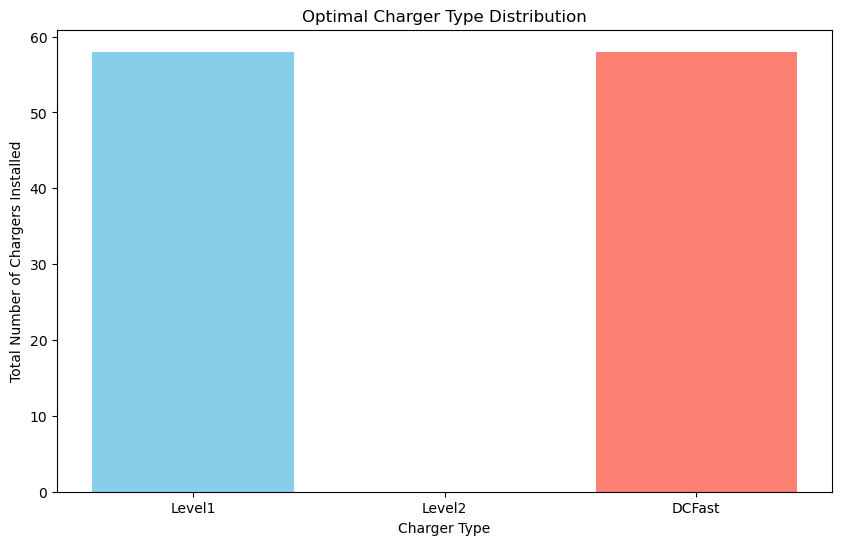

In [23]:
# plot Optimal Charger Type Distribution:", optimal_charger_type)
import matplotlib.pyplot as plt

# Extract the optimal number of each type of charger for each county from the solution
optimal_charger_distribution = {
    county: {charger: charger_type[county, charger].X for charger in charger_types}
    for county in baseline_demand.keys()
}

# Create a dictionary to sum the total number of each type of charger across all counties
total_charger_distribution = {charger: 0 for charger in charger_types}
for county in optimal_charger_distribution:
    for charger in charger_types:
        total_charger_distribution[charger] += optimal_charger_distribution[county][charger]

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.bar(total_charger_distribution.keys(), total_charger_distribution.values(), color=['skyblue', 'lightgreen', 'salmon'])
plt.title("Optimal Charger Type Distribution")
plt.xlabel("Charger Type")
plt.ylabel("Total Number of Chargers Installed")
plt.show()


#### Extract second stage results

In [14]:
# Ensure the model was solved successfully
if second_stage_model.Status == GRB.OPTIMAL:
    # Extract optimal results for energy usage
    optimal_energy_usage = {
        (county, scenario): energy_usage[county, scenario].X
        for county in baseline_demand.keys()
        for scenario in scenarios.keys()
    }

    # Extract unmet demand (shortfall)
    optimal_shortfall = {
        (county, scenario): shortfall[county, scenario].X
        for county in baseline_demand.keys()
        for scenario in scenarios.keys()
    }

    # Extract exceeded capacity (excess)
    optimal_excess = {
        (county, scenario): excess_capacity[county, scenario].X
        for county in baseline_demand.keys()
        for scenario in scenarios.keys()
    }

    # Print the results (optional)
    print("Optimal Energy Usage:", optimal_energy_usage)
    print("Unmet Demand (Shortfall):", optimal_shortfall)
    print("Exceeded Capacity (Excess):", optimal_excess)
else:
    print("Second Stage Optimization Failed")

Optimal Energy Usage: {('Alameda', 'Scenario1'): 54714.06864589571, ('Alameda', 'Scenario2'): 57506.02674535987, ('Alameda', 'Scenario3'): 66211.5370151902, ('Alpine', 'Scenario1'): 10.0, ('Alpine', 'Scenario2'): 14.335819489107593, ('Alpine', 'Scenario3'): 13.732854276621048, ('Amador', 'Scenario1'): 198.58897503790638, ('Amador', 'Scenario2'): 236.9317101207483, ('Amador', 'Scenario3'): 276.64384350182746, ('Butte', 'Scenario1'): 1282.3039238404451, ('Butte', 'Scenario2'): 1336.250639593854, ('Butte', 'Scenario3'): 1417.311614403917, ('Calaveras', 'Scenario1'): 320.2231216088394, ('Calaveras', 'Scenario2'): 357.01552898963917, ('Calaveras', 'Scenario3'): 382.38162708546434, ('Colusa', 'Scenario1'): 63.859797326154805, ('Colusa', 'Scenario2'): 65.3271419691013, ('Colusa', 'Scenario3'): 64.71756481102786, ('Contra Costa', 'Scenario1'): 30828.03763840959, ('Contra Costa', 'Scenario2'): 32485.004497467566, ('Contra Costa', 'Scenario3'): 32072.578773908648, ('Del Norte', 'Scenario1'): 98.

### Choropleth maps

#### Shapefile

In [15]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Load county shapefile or GeoJSON
# Replace with the path to your GeoJSON or shapefile
file_path_shp = 'CA_Counties.shp'
county_geo = gpd.read_file(file_path_shp)

county_geo.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,Shape_Leng,Shape_Area,geometry
0,06,091,00277310,06091,Sierra,Sierra County,06,H1,G4020,None,None,None,A,2.468695e+09,2.329911e+07,+39.5769252,-120.5219926,375602.758281,4.200450e+09,"POLYGON ((-13431319.751 4821511.426, -13431312..."
1,06,067,00277298,06067,Sacramento,Sacramento County,06,H1,G4020,472,40900,None,A,2.499984e+09,7.542543e+07,+38.4500161,-121.3404408,406584.174167,4.205516e+09,"POLYGON ((-13490651.476 4680831.603, -13490511..."
2,06,083,00277306,06083,Santa Barbara,Santa Barbara County,06,H1,G4020,None,42200,None,A,7.084063e+09,2.729752e+09,+34.5370572,-120.0399729,891686.747247,1.449841e+10,"MULTIPOLYGON (((-13440081.316 4150394.004, -13..."
3,06,009,01675885,06009,Calaveras,Calaveras County,06,H1,G4020,None,None,None,A,2.641785e+09,4.384187e+07,+38.1838996,-120.5614415,367005.879680,4.356213e+09,"POLYGON ((-13428575.483 4627725.227, -13428534..."
4,06,111,00277320,06111,Ventura,Ventura County,06,H1,G4020,348,37100,None,A,4.771988e+09,9.473454e+08,+34.3587415,-119.1331432,527772.242190,8.413293e+09,"MULTIPOLYGON (((-13283668.940 4059436.934, -13..."


#### optimal increase map

<Figure size 1200x800 with 0 Axes>

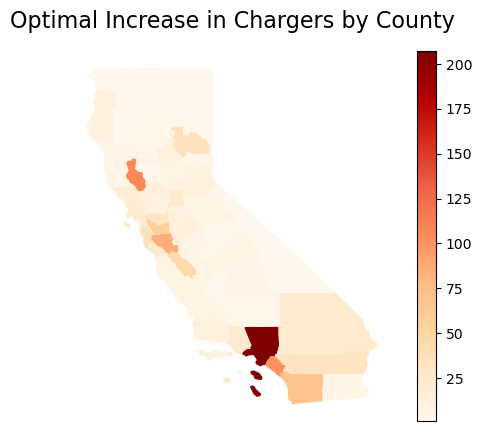

In [16]:
# Step 2: Create a DataFrame for optimal increases in chargers

# Convert dictionary to DataFrame
optimal_increase_df = pd.DataFrame(list(optimal_chargers.items()), columns=['County', 'Optimal_Increase'])

# Step 3: Merge the GeoDataFrame with the optimization data
# Ensure both datasets have matching keys for the counties
county_geo = county_geo.merge(optimal_increase_df, how="left", left_on="NAME", right_on="County")

# Step 4: Plot the choropleth map
plt.figure(figsize=(12, 8))
county_geo.plot(
    column="Optimal_Increase",  # The data to visualize
    cmap="OrRd",               # Color map
    legend=True,               # Show legend
    missing_kwds={"color": "lightgrey", "label": "No Data"}  # Handle missing data
)
plt.title("Optimal Increase in Chargers by County", fontsize=16)
plt.axis("off")  # Turn off axes
plt.show()

#### total ev map

<Figure size 1200x800 with 0 Axes>

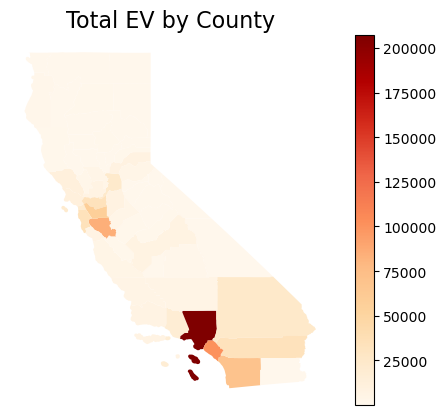

In [17]:
# Create the DataFrame
total_ev_df = data[['County', 'Total_EV']]

# Step 3: Merge the GeoDataFrame with the total_ev data
# Ensure both datasets have matching keys for the counties
county_geo = county_geo.merge(total_ev_df, how="left", left_on="NAME", right_on="County")

# Step 4: Plot the choropleth map
plt.figure(figsize=(12, 8))
county_geo.plot(
    column="Total_EV",  # The data to visualize
    cmap="OrRd",               # Color map
    legend=True,               # Show legend
    missing_kwds={"color": "lightgrey", "label": "No Data"}  # Handle missing data
)
plt.title("Total EV by County", fontsize=16)
plt.axis("off")  # Turn off axes
plt.show()

<Figure size 1200x800 with 0 Axes>

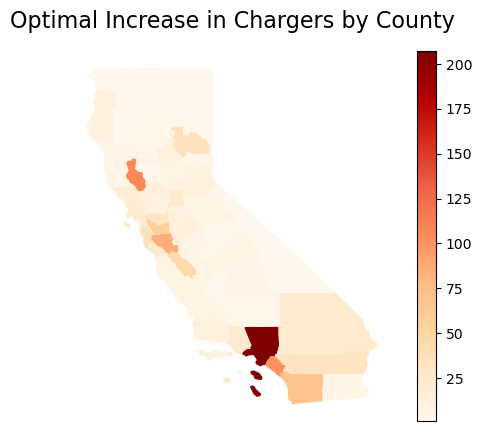

In [18]:
# plot optimal increase in chargers
plt.figure(figsize=(12, 8))
county_geo.plot(
    column="Optimal_Increase",  # The data to visualize
    cmap="OrRd",               # Color map
    legend=True,               # Show legend
    missing_kwds={"color": "lightgrey", "label": "No Data"}  # Handle missing data
)
plt.title("Optimal Increase in Chargers by County", fontsize=16)
plt.axis("off")  # Turn off axes
plt.show()


In [19]:
optimal_chargers

{'Alameda': 57,
 'Alpine': 5,
 'Amador': 9,
 'Butte': 12,
 'Calaveras': 8,
 'Colusa': 2,
 'Contra Costa': 33,
 'Del Norte': 2,
 'El Dorado': 12,
 'Fresno': 7,
 'Glenn': 5,
 'Humboldt': 12,
 'Imperial': 6,
 'Inyo': 1,
 'Kern': 4,
 'Kings': 2,
 'Lake': 106,
 'Lassen': 1,
 'Los Angeles': 207,
 'Madera': 3,
 'Marin': 22,
 'Mariposa': 1,
 'Mendocino': 5,
 'Merced': 6,
 'Modoc': 1,
 'Mono': 1,
 'Monterey': 7,
 'Napa': 11,
 'Nevada': 7,
 'Orange': 101,
 'Placer': 11,
 'Plumas': 34,
 'Riverside': 33,
 'Sacramento': 23,
 'San Benito': 45,
 'San Bernardino': 24,
 'San Diego': 69,
 'San Francisco': 21,
 'San Joaquin': 11,
 'San Luis Obispo': 9,
 'San Mateo': 34,
 'Santa Barbara': 12,
 'Santa Clara': 84,
 'Santa Cruz': 22,
 'Shasta': 4,
 'Sierra': 3,
 'Siskiyou': 1,
 'Solano': 10,
 'Sonoma': 18,
 'Stanislaus': 14,
 'Sutter': 9,
 'Tehama': 3,
 'Trinity': 2,
 'Tulare': 6,
 'Tuolumne': 9,
 'Ventura': 23,
 'Yolo': 13,
 'Yuba': 9}